# Sparse point cloud reconstruction of the scene using 16 cameras placed at the vertices of the regular polygon

In [ ]:
!pip install open3d

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 52.7 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import scipy as sp
import json
#import open3d as o3d

In [ ]:
def plot_imgsN(*args):
  N = len(args)
  rows = np.ceil(np.sqrt(N/2)).astype(int)
  cols = 2 * rows
  fig, axs = plt.subplots(rows, cols, figsize=(16, 8))
  fig.tight_layout()
  for i,ax in enumerate(axs.flatten()):
    if i >= N:
      ax.set_axis_off()
      continue
    ax.imshow(cv2.cvtColor(args[i],cv2.COLOR_BGR2RGB))
    ax.set_axis_off()

In [ ]:
def plot_imgs2(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(15, 20))
  for a in ax:
    a.set_axis_off()
  print(type(ax))
  ax[0].imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
  ax[1].imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))

In [ ]:
a = cv2.imread("frame_0.png")
a.shape

(1000, 1000, 3)

In [ ]:
 1000/(2*np.tan(40/180*np.pi/2))

1373.7387097273113

In [ ]:
imgs = []
for i in range(16):
  imgs.append(cv2.imread("frame_" + str(i) + ".png"))

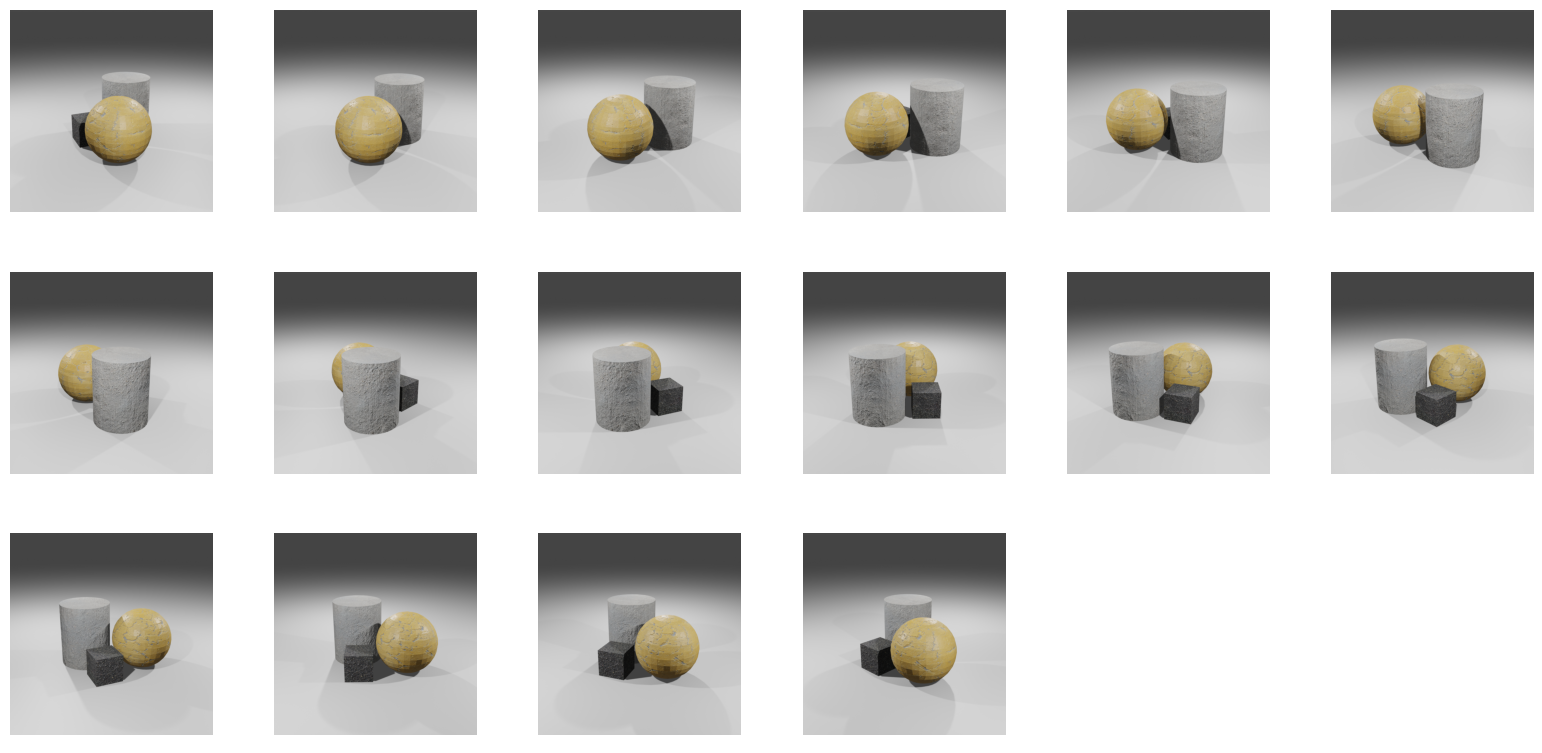

In [ ]:
plot_imgsN(*imgs)

In [ ]:
cam_data = json.load(open("metadata.txt"))

In [ ]:
K = np.array(cam_data["intrinsics"])
cams_R = np.array(cam_data["extrinsics"]["orients"])
cams_X = np.array(cam_data["extrinsics"]["locs"])

In [ ]:
K

array([[1.38888889e+03, 0.00000000e+00, 5.00000000e+02],
       [0.00000000e+00, 1.38888889e+03, 5.00000000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [ ]:
# build projection matrices P = K [R|t]
# becouse of the covention used x_w = Rwc*x_c + t_wc:  R = Rwc.T t = - Rwc.T*t_wc
cams_P = []
for R, X in zip(cams_R, cams_X):
  Rt = np.hstack([R.T, - (R.T @ X).reshape(-1,1)]) # [R|t]
  P = np.matmul(K,Rt)
  cams_P.append(P)

## Test individual object point triangulation

Imitate perfect-stereo pair setup K, X1, R1, X2, R2

In [ ]:
K = np.array([
   [600., 0, 300.,],
    [0, 600., 300.],
   [0 , 0, 1]
])

In [ ]:
phi = - np.pi/2
R1 = np.array([
    [1, 0, 0],
    [0, np.cos(phi), -np.sin(phi)],
    [0, np.sin(phi), np.cos(phi)]
])
R2 = R1

In [ ]:
# deviation from the perfect stereo pair
da = np.pi / 180 * 5
dR = R1 = np.array([
    [np.cos(da), -np.sin(da), 0],
    [np.sin(da), np.cos(da), 0],
    [0, 0, 1]
])

In [ ]:
X1 = np.array([0., 0., 0.])
X2 = np.array([0.1, 0, 0])

In [ ]:
cams_R = [R1, R2@dR]
cams_X = [X1, X2]

Projection matrices on image plane

In [ ]:
# build projection matrices P = K [R|t]
# R = Rwc.T, t = - Rwc.T*twc
cams_P = []
for R, X in zip(cams_R, cams_X):
  Rt = np.hstack([R.T, - (R.T @ X).reshape(-1,1)]) # [R|t]
  P = np.matmul(K,Rt)
  cams_P.append(P)

Object point to project

In [ ]:
# object point in homogenious coordinates
obj_pt = np.array([1.0, 6.0, 1.0, 1.0])

Project on image plane (1 method)

In [ ]:
img_pts = []
for P in cams_P:
  im_pt = P @ obj_pt
  im_pt /= im_pt[2]
  img_pts.append(im_pt[:2])

In [ ]:
img_pts

[array([1211.47749275, 3834.00746748]), array([380.94194855, 192.53651334])]

Project on image plane (2 method)

In [ ]:
img_pts_ = []
for R, X in zip(cams_R, cams_X):
  rvec, _ = cv2.Rodrigues(R.T)
  im_pt, _ = cv2.projectPoints(obj_pt[:3].reshape(1,-1), rvec, -(R.T@X).reshape(1,-1), K, np.zeros(5))
  img_pts_.append(im_pt)

In [ ]:
img_pts_

[array([[[1211.47749275, 3834.00746748]]]),
 array([[[380.94194855, 192.53651334]]])]

Triangulation (recover object point back from the pixel coordiantes)

In [ ]:
tr_obj_pts = cv2.triangulatePoints(cams_P[0], cams_P[1], img_pts_[0].squeeze(0).T, img_pts_[1].squeeze(0).T)
tr_obj_pts /= tr_obj_pts[3] # to heterogenious coordinates
tr_obj_pts[:3]

array([[1.],
       [6.],
       [1.]])

## Triangualate for 1 camera pair

In [ ]:
def get_matches(im1, im2):
  im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
  sift = cv2.SIFT.create()
  kp1, des1 = sift.detectAndCompute(im1_gray, None)
  kp2, des2 = sift.detectAndCompute(im2_gray, None)
  bf = cv2.BFMatcher() # brute force feature matcher
  matches = bf.knnMatch(des1,des2,k=2) # find for each feature 2 closest according to euclidian distance
  # Apply ratio test
  good_matches = []
  thershold = 0.75
  for m,n in matches:
      if m.distance < thershold*n.distance:
          good_matches.append(m)
  N_pts = len(good_matches)
  good_kp1 = np.zeros((N_pts, 2))
  good_kp2 = np.zeros((N_pts, 2))
  for i in range(N_pts):
    good_kp1[i] = kp1[good_matches[i].queryIdx].pt
    good_kp2[i] = kp2[good_matches[i].trainIdx].pt
  return good_kp1, good_kp2

In [ ]:
kp1, kp2 = get_matches(imgs[14], imgs[15])

In [ ]:
img_ = imgs[14].copy()
for p in kp1:
  img_ = cv2.circle(img_, p.astype(int), 5, (0,0,255), 5)

Points wich will be triangulated

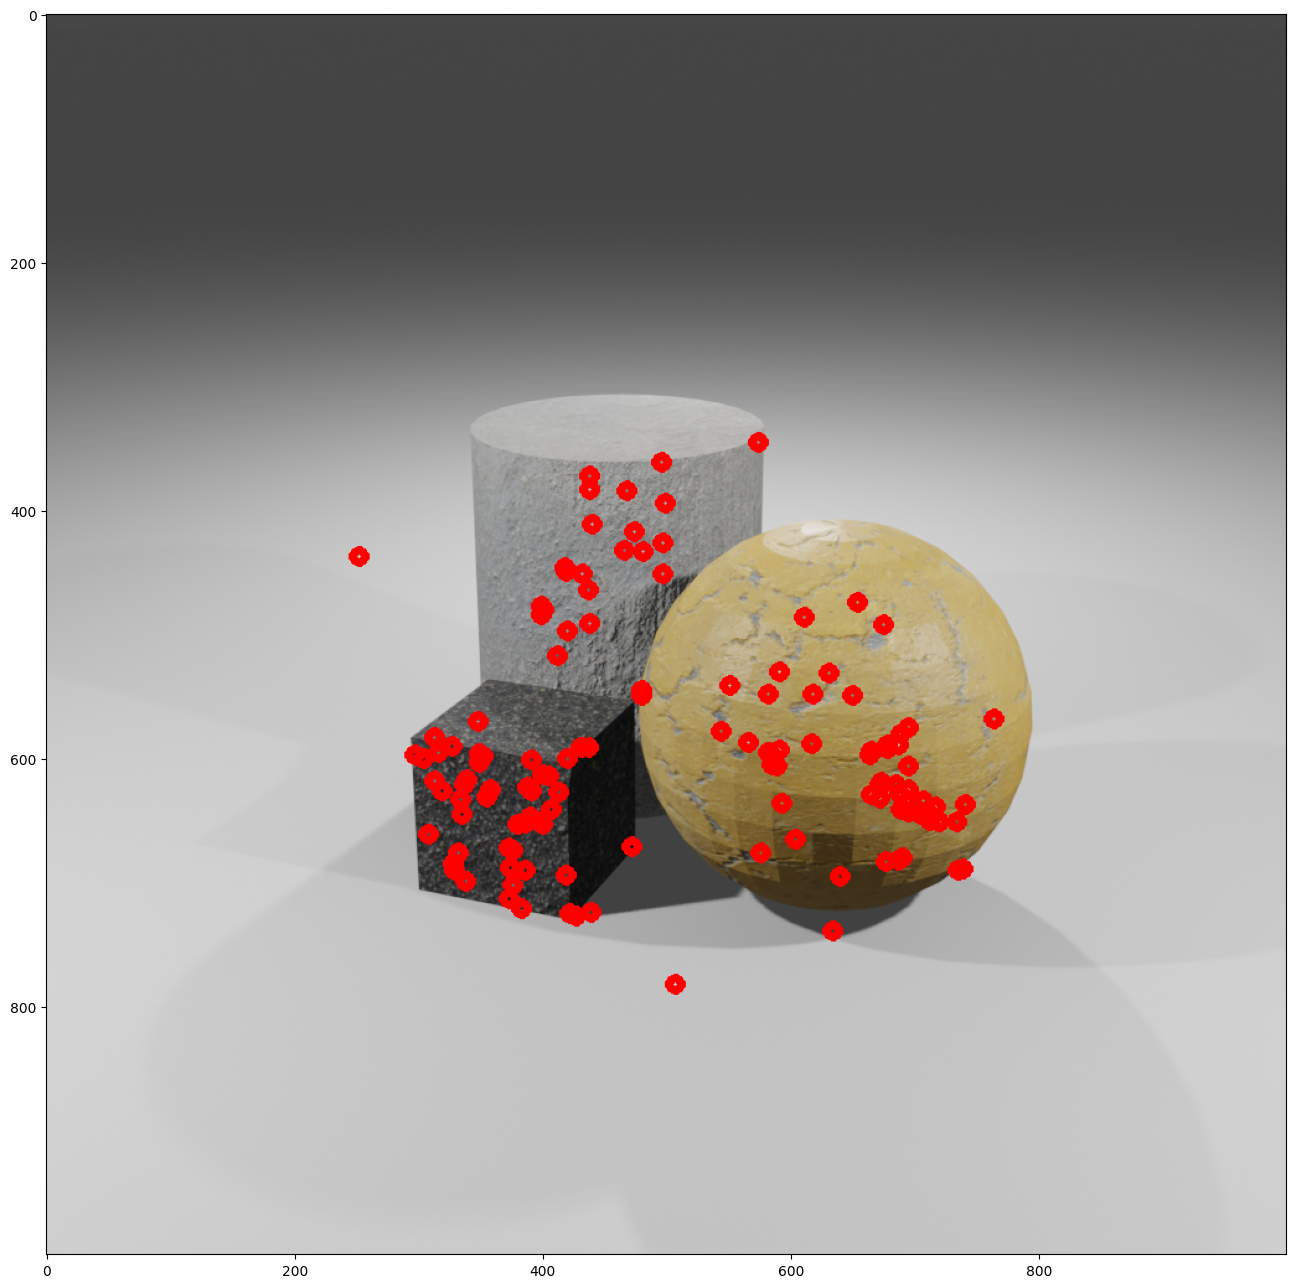

In [ ]:
plt.figure(figsize = (16,32))
plt.imshow(cv2.cvtColor(img_, cv2.COLOR_BGR2RGB))

In [ ]:
obj_pts = cv2.triangulatePoints(cams_P[14], cams_P[15], kp1.T, kp2.T)

In [ ]:
obj_pts /= obj_pts[3]

In [ ]:
colors = imgs[14][kp1.T[1].astype(int), kp1.T[0].astype(int), :]

Create point cloud

In [ ]:
# Pass points to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(obj_pts[:3].T)
pcd.colors = o3d.utility.Vector3dVector(colors/255.)
#o3d.io.write_point_cloud("sync.ply", pcd)

Visualize


In [ ]:
pcl1 = o3d.io.read_point_cloud("point_cloud.ply")

In [ ]:
o3d.visualization.draw_plotly([pcd]) #point_sample_factor = 0.1

##Combine points from all possible 16 camera pairs

In [ ]:
N = len(imgs)
points = np.zeros((3,1)) # this values must be deleted afterwards
colors = np.zeros((1,3))
for i in range(N):
  k1, k2 = get_matches(imgs[i], imgs[(i+1) % N])
  obj_pts = cv2.triangulatePoints(cams_P[i], cams_P[(i+1) % N], k1.T, k2.T)
  obj_pts /= obj_pts[3] # to heterogenious coordinates
  obj_cols = imgs[i][k1.T[1].astype(int), k1.T[0].astype(int), :]
  points = np.hstack((points, obj_pts[:3]))
  colors = np.vstack((colors, obj_cols))


In [ ]:
# filter outliers
t = 8 # keep points in the cube with the side 8m
cond = (points > -t) & (points < t)

In [ ]:
# Pass points to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points.T[cond])
pcd.colors = o3d.utility.Vector3dVector(colors[cond]/255.)
o3d.io.write_point_cloud("sparce_pcd_scene.ply", pcd, write_ascii = True)

True

In [ ]:
o3d.visualization.draw_plotly([pcd]) #point_sample_factor = 0.1